# P5: PyTorch and Policy Gradient Methods

[Instructions are the same as they have been.]

In this assignment, you will be implementing your own approximate reinforcement learning methods. To begin, you'll need to install a few packages: `torch` (the PyTorch package, focused on training deep learning algorithms) and `gymnasium`, which implements a few classical control environments that we will be using to evaluate our RL algorithms. Run the following to make sure they are installed:

In [3]:
%pip install gymnasium "gymnasium[classic-control]" torch==2.0.0

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
## Starter Code
from IPython import display
import gymnasium as gym
import torch
from torch import nn
import numpy as np
import random
import matplotlib.pyplot as plt


def smooth_data(data, window_width=50):
    summed_data = np.cumsum(data)
    sm_data = (summed_data[window_width:] - summed_data[:-window_width]) / window_width
    return np.concatenate([np.zeros(window_width), sm_data])


def rollout(env, policy, epsilon, do_visualize=False):
    state, _ = env.reset()
    done = False
    data = []
    if do_visualize:
        img = plt.imshow(env.render())
    while not done:
        if do_visualize:
            img.set_data(env.render())
            display.display(plt.gcf())
            display.clear_output(wait=True)
        action = policy.sample_action(state, epsilon)
        try:
            new_state, reward, terminated, truncated, _ = env.step(action)
        except:
            new_state, reward, terminated, truncated, _ = env.step([action])
        done = terminated or truncated
        data.append((state, action, reward, new_state, done))
        state = new_state

    return data


## P5.1 Curve Fitting

As a starting point, we will go through some simple code to test your understanding of Gradient Descent to solve a curve fitting problem.

PyTorch, like most popular deep learning tools, supports "autodiff", a tool for automatically computing derivatives of many common functions used in neural networks, making it easy to perform gradient descent. PyTorch has built-in optimization tools as well, which we used to implement curve fitting in the L08 breakout session code, reproduced here as a starting point for the remainder of this question.

**TASK** Run the "Curve Fitting Starter Code" below and confirm that your FitFunction approximates the data.

Step:      0  |    y = 0.675 + -2.331*x + 1.692*x^2 + 1.841*x^3  |  Loss: 0.15075714886188507
Step:    250  |    y = 0.789 + -3.295*x + 1.776*x^2 + 1.040*x^3  |  Loss: 0.09082482755184174
Step:    500  |    y = 0.836 + -3.805*x + 1.770*x^2 + 0.565*x^3  |  Loss: 1.4265931844711304
Step:    750  |    y = 0.970 + -3.924*x + 1.828*x^2 + 0.427*x^3  |  Loss: 7.353857040405273
Step:   1000  |    y = 1.107 + -3.890*x + 1.918*x^2 + 0.402*x^3  |  Loss: 12.945703506469727
Step:   1250  |    y = 1.168 + -3.810*x + 1.944*x^2 + 0.410*x^3  |  Loss: 5.699977874755859
Step:   1500  |    y = 1.222 + -3.740*x + 1.975*x^2 + 0.397*x^3  |  Loss: 0.026512248441576958
Step:   1750  |    y = 1.252 + -3.643*x + 1.984*x^2 + 0.396*x^3  |  Loss: 5.582817554473877
Step:   2000  |    y = 1.257 + -3.553*x + 1.972*x^2 + 0.389*x^3  |  Loss: 5.814131736755371
Step:   2250  |    y = 1.295 + -3.444*x + 1.978*x^2 + 0.386*x^3  |  Loss: 2.312570571899414
Step:   2500  |    y = 1.332 + -3.331*x + 1.972*x^2 + 0.380*x^3  |  Los

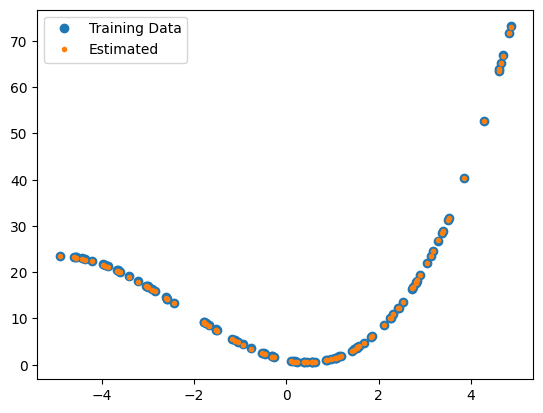

In [5]:
# Curve Fitting Starter Code [From L08B]

import numpy as np
import matplotlib.pyplot as plt
import torch

class FitFunction(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))
        self.d = torch.nn.Parameter(torch.randn(()))

    def forward(self, x):
        return self.a + self.b * x + self.c * x ** 2 + self.d * x ** 3

    def string(self):
        return f'  y = {self.a.item():.3f} + {self.b.item():.3f}*x + {self.c.item():.3f}*x^2 + {self.d.item():.3f}*x^3'


def compute_loss(y, y_pred):
    return (y_pred - y) ** 2

# Generate some data from the curve we're trying to fit
xs = np.random.rand(100) * 10 - 5
ys = 1 - 2 * xs + 2 * (xs**2) + 0.3 * (xs ** 3)
plt.plot(xs, ys, 'o')

# Instantiate the function with random guesses of the coefficients
model = FitFunction()

# Optimization loop
num_optim_steps = 10000
learning_rate = 1e-2
optim = torch.optim.Adam(model.parameters(),lr = learning_rate)

for t in range(num_optim_steps):
    # Get a random data point
    ind = np.random.randint(0, len(xs))
    y = ys[ind]

    # Make a prediction and compute the loss
    y_pred = model(xs[ind])
    loss = compute_loss(y, y_pred)

    # Debug print outputs
    if t % 250 == 0:
        print(f"Step: {t:6d}  |  " +  model.string() + f"  |  Loss: {loss.item()}")

    # .backward() computes the gradient that the optimizer uses to train
    loss.backward()  # calculate the gradient
    optim.step()     # update the parameters
    optim.zero_grad() # remove all the previous gradient values for the next calculation

# Compute the estimated values for all the data points (on training data...)
y_estimated = model(torch.tensor(xs)).detach().numpy()
plt.plot(xs, y_estimated, '.')
plt.gca().legend(['Training Data', 'Estimated'])
None


## P5.1.1 Using an alternate update rule

We use the common "squared loss", equivalent to the "Mean Squared Error" used in linear algebra curve fitting problems. The loss is defined as follows:

$$\text{Loss} = \frac{1}{2}(y_\text{pred} - y) ^ 2 $$

In class, we discussed that the squared loss function gives rise to the following update rule (via gradient descent):

$$ \theta_\text{new} = \theta_\text{old} + \eta \nabla_\theta \text{Loss} \text{ [Update Rule \#1]}$$

$$ \theta_\text{new} = \theta_\text{old} + \eta (y_\text{pred} - y) \nabla_\theta y_\text{pred} \text{ [Update Rule \#2]}$$

where $\eta$ is the learning rate and $\nabla_\theta$ is the gradient with respect to the parameters $\theta$. Note that both rules are equivalent to one another. This can be easily derived from the chain rule, since $\nabla (a - f(\theta))^2 = 2 (a - \theta) \nabla f(\theta)$. You will show this equivalence in PyTorch by writing a new `compute_loss` function that matches [Update Rule] above.

In the RL scenarios in the questions below, you will want to be able to optimize scenarios that resemble [Update Rule #2]. As practice for this, your first task is to define a new `compute_loss_v2` function that looks like [Update Rule #2]. Note that using `loss = (y_pred - y) * y_pred` will *not* succeed, since both terms are differentiable with respect to the parameters $\theta$. To avoid this issue, you'll need to "detach" the terms for which you don't want to compute a gradient. There are two ways to do this in PyTorch:

```python

# _V1_
with torch.no_grad():
    # This is treated as a constant by PyTorch
    y_pred_constant = model(x)

# _V2_
# This is also treated as a constant by PyTorch
y_pred_constant = model(x).detach()
```

**TASK/CODE LISTING** Implement `compute_loss_v2`, which should rely on one of the two "detach" functions above. Note that the result you obtain in using this function should closely resemble the first version and the fit function should closely fit the data. You do not need to include the resulting plot in your writeup.

In [6]:
# Starter Code: compute loss
def compute_loss_v2(y, y_pred):
    y_pred_constant = (y_pred-y).detach()
    return y_pred_constant*y_pred
    # raise NotImplementedError()

Step:      0  |    y = 0.060 + 0.267*x + 1.427*x^2 + 0.405*x^3  |  Loss: -0.09004577994346619
Step:    250  |    y = 0.700 + -0.457*x + 1.987*x^2 + 0.223*x^3  |  Loss: -3.0720889568328857
Step:    500  |    y = 0.717 + -1.172*x + 2.035*x^2 + 0.253*x^3  |  Loss: 27.42144775390625
Step:    750  |    y = 0.825 + -1.569*x + 2.024*x^2 + 0.272*x^3  |  Loss: 0.2518835961818695
Step:   1000  |    y = 0.901 + -1.810*x + 2.024*x^2 + 0.288*x^3  |  Loss: -0.04693109542131424
Step:   1250  |    y = 0.953 + -1.937*x + 2.005*x^2 + 0.295*x^3  |  Loss: -0.7971575856208801
Step:   1500  |    y = 0.990 + -1.979*x + 2.002*x^2 + 0.299*x^3  |  Loss: -0.029746871441602707
Step:   1750  |    y = 1.000 + -1.998*x + 2.002*x^2 + 0.299*x^3  |  Loss: 0.016269251704216003
Step:   2000  |    y = 0.999 + -1.999*x + 2.000*x^2 + 0.298*x^3  |  Loss: -0.0025406291242688894
Step:   2250  |    y = 1.006 + -1.999*x + 2.002*x^2 + 0.300*x^3  |  Loss: 0.17318783700466156
Step:   2500  |    y = 1.008 + -1.999*x + 2.000*x^2 + 0.

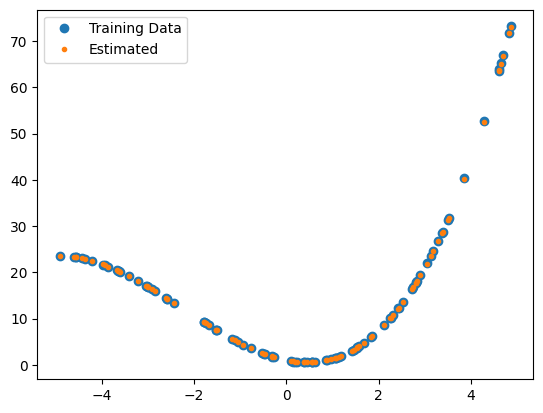

In [7]:
# Use the new loss function to train.

model = FitFunction()

# Optimization loop
num_optim_steps = 10000
learning_rate = 2e-2
optim = torch.optim.Adam(model.parameters(),lr = learning_rate)

for t in range(num_optim_steps):
    # Get a random data point
    ind = np.random.randint(0, len(xs))
    y = ys[ind]

    # Make a prediction and compute the loss
    y_pred = model(xs[ind])
    loss = compute_loss_v2(y, y_pred)

    # Debug print outputs
    if t % 250 == 0:
        print(f"Step: {t:6d}  |  " +  model.string() + f"  |  Loss: {loss.item()}")

    # .backward() computes the gradient that the optimizer uses to train
    loss.backward()
    optim.step()
    optim.zero_grad()

# Compute the estimated values for all the data points (on training data...)
y_estimated = model(torch.tensor(xs)).detach().numpy()
plt.plot(xs, ys, 'o')
plt.plot(xs, y_estimated, '.')
plt.gca().legend(['Training Data', 'Estimated'])
None

## P5.1.2 Fitting to 2D data

I have provided you with some sample `2D` data that you should fit to using Gradient Descent.

**TASK** Complete `FitFunction2D` and write a script (using the 1D case as a starting point) that estimates the `zs` from the `xs` and `ys`.

**CODE LISTING** Include the resulting class definition and script in your writeup. If run, your code should nearly perfectly fit the data I have provided.

In [8]:
# Starter Code: 2D Data

class FitFunction2D(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))
        self.d = torch.nn.Parameter(torch.randn(()))
        self.e = torch.nn.Parameter(torch.randn(()))
        self.f = torch.nn.Parameter(torch.randn(()))

    def forward(self, xs, ys):
        return self.a+self.b*xs+self.c*ys+self.d*xs**2 \
                + self.e*ys**2 + self.f*xs*ys

    def string(self):
        # return "Replace this if you wish! It's only for debugging/sanity checking"
        return f'  z = {self.a.item():.3f} + {self.b.item():.3f}*x + {self.c.item():.3f}*y + {self.d.item():.3f}*x^2 + {self.e.item():.3f}*y^2 + {self.f.item():.3f}*x*y'

Step:      0  |    z = 1.052 + 0.904*x + 1.339*y + -1.308*x^2 + 0.150*y^2 + -1.049*x*y  |  Loss: 153.00401306152344
Step:    250  |    z = 1.256 + 0.774*x + 1.481*y + -0.974*x^2 + 0.123*y^2 + -1.081*x*y  |  Loss: 8.053112030029297
Step:    500  |    z = 1.371 + 0.600*x + 1.562*y + -0.727*x^2 + 0.005*y^2 + -1.080*x*y  |  Loss: 1722.4124755859375
Step:    750  |    z = 1.486 + 0.375*x + 1.562*y + -0.483*x^2 + -0.121*y^2 + -1.059*x*y  |  Loss: 0.06002260744571686
Step:   1000  |    z = 1.618 + 0.091*x + 1.644*y + -0.194*x^2 + -0.231*y^2 + -1.129*x*y  |  Loss: 99.2127914428711
Step:   1250  |    z = 1.617 + -0.119*x + 1.694*y + -0.018*x^2 + -0.395*y^2 + -1.083*x*y  |  Loss: 158.2496337890625
Step:   1500  |    z = 1.691 + -0.345*x + 1.735*y + 0.221*x^2 + -0.481*y^2 + -1.090*x*y  |  Loss: 23.10550880432129
Step:   1750  |    z = 1.654 + -0.540*x + 1.752*y + 0.341*x^2 + -0.654*y^2 + -1.091*x*y  |  Loss: 57.30001449584961
Step:   2000  |    z = 1.624 + -0.701*x + 1.788*y + 0.446*x^2 + -0.756*

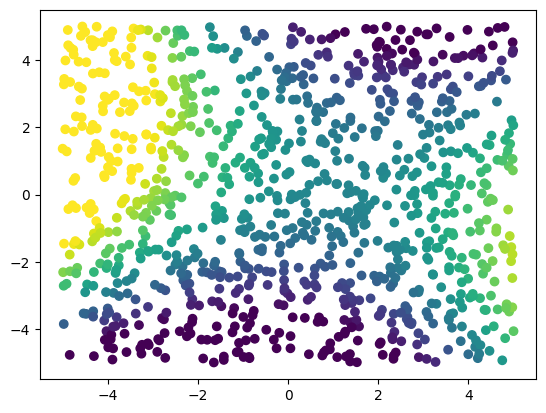

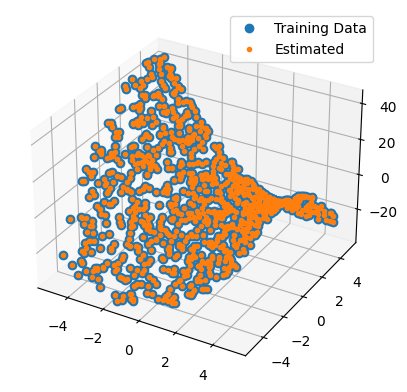

In [9]:
def compute_loss(y, y_pred):
    return (y_pred - y) ** 2

# Generate some data from the curve we're trying to fit
xs = np.random.rand(1000) * 10 - 5
ys = np.random.rand(1000) * 10 - 5
zs = -1 - 2 * xs + 2 * ys + xs ** 2 - ys ** 2 - xs * ys


plt.figure()
# plt.figure().add_subplot(projection='3d')
plt.scatter(xs, ys, c=zs, vmin=-20, vmax=20)

# Instantiate the function with random guesses of the coefficients
model2D = FitFunction2D()

# Optimization loop
num_optim_steps = 10000
learning_rate = 3e-3
optim = torch.optim.Adam(model2D.parameters(), lr = learning_rate)

for t in range(num_optim_steps):
    # Get a random data point
    ind = np.random.randint(0, len(xs))
    z = zs[ind]

    # Make a prediction and compute the loss
    z_pred = model2D(xs[ind], ys[ind])
    loss = compute_loss(z, z_pred)

    # Debug print outputs
    if t % 250 == 0:
        print(f"Step: {t:6d}  |  " +  model2D.string() + f"  |  Loss: {loss.item()}")

    # .backward() computes the gradient that the optimizer uses to train
    loss.backward()  # calculate the gradient
    optim.step()     # update the parameters
    optim.zero_grad() # remove all the previous gradient values for the next calculation

# Compute the estimated values for all the data points (on training data...)
z_estimated = model2D(torch.tensor(xs),torch.tensor(ys)).detach().numpy()
plt.figure().add_subplot(projection='3d')
plt.plot(xs, ys, zs, 'o')
# plt.plot(xs, y_estimated, '.')
plt.plot(xs, ys, z_estimated, '.')
plt.gca().legend(['Training Data', 'Estimated'])
None

## P5.2 Policy Learning in the CartPole Environment

In class we discussed the CartPole Environment, described and defined in detail here: https://gymnasium.farama.org/environments/classic_control/cart_pole/ . You will be using this environment to develop the three policy gradient algorithms we defined in Lecture 09.

### P5.2.1 Defining the Policy

Below, I have provided you with a partial implementation of the `PolicyApprox` function, which will take in the state of the environment and return a probability for each action. I have defined a simple neural network that ends with a "softmax" operation, ensuring that the output is normalized and so is a valid probability distribution.

**TASK/CODE** Complete the `sample_action` and `get_action_log_prob` functions in the partial implementation of the `PolicyApprox` class. Note that the `sample_action` function takes in a parameter `epsilon`, so that your policy is an epsilon-greedy "soft policy": epsilon percent of the time, the policy should pick a random action with uniform probability. You may find `np.random.choice` a helpful function for this in your implementation. Include the completed functions in your writeup.

**TASK** Once you've completed the approximate policy class, run the "Results and Plotting" code below it a few times and observe the results.

**QUESTION** (2-4 sentences) "Roughly how many steps does the typical trial manage before the pendulum falls to the side? Describe what behavior you should expect to keep the pendulum up.

In [2]:
## Policy Approximation Starter Code

class PolicyApprox(torch.nn.Module):
    def __init__(self, n_states, n_actions):
        super().__init__()
        # A single hidden layer neural network
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_states, 32),
            nn.Tanh(),
            nn.Linear(32, n_actions),
            nn.Softmax()
        )

    def forward(self, state):
        return self.linear_relu_stack(torch.tensor(state, dtype=torch.float))

    def sample_action(self, state, epsilon=0.0):
        # Move data out of PyTorch and into numpy
        policy_outputs = self.forward(state).detach().numpy()
        if policy_outputs[0] < 1e-6:
            policy_outputs[0] = 1e-6
            policy_outputs[1] = 1-1e-6
        if policy_outputs[1] < 1e-6:
            policy_outputs[0] = 1-1e-6
            policy_outputs[1] = 1e-6
        if np.random.uniform() > epsilon:
            action = np.random.choice([0,1], 1, p=policy_outputs)[0]
        else:
            action = np.random.choice([0,1], 1)[0]
        return action

    def get_action_log_prob(self, state, action):
        """Return the log of the probability."""
        
        probs = self.linear_relu_stack(torch.tensor(state, dtype=torch.float))
        return torch.log(probs[action])

Num steps before failure: 14


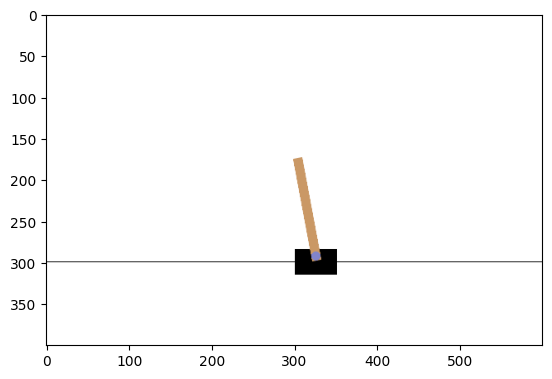

In [3]:
# Results and Plotting

env = gym.make('CartPole-v0', render_mode='rgb_array')

policy = PolicyApprox(n_states=len(env.observation_space.low),
                  n_actions=env.action_space.n)

rollout_data = rollout(env, policy, epsilon=0, do_visualize=True)

print(f"Num steps before failure: {len(rollout_data)}")

### P5.2.2 Implementing REINFORCE

In L09, we discussed the REINFORCE algorithm, as presented in Chapter 13.3 in Sutton & Barto. Below, I have presented you with a partial implementation of REINFORCE.

**TASK/CODE** Complete the REINFORCE algorithm below using the lecture slides or Sutton & Barto as a reference. Include your definition of the loss function in your writeup. Note that to implement the algorithm, you may need to use what you learned in P5.1.1, so make sure you've done that question first.

**PLOTS** Run the Results & Plotting code using your newly-implemented REINFORCE implementation. Include the plot in your writeup.

**QUESTION** (2–4 sentences) Run the Results & Plotting code a few more times (3–5 times will be sufficient) and comment on the similarities and differences between the results and behavior of the system (e.g., how does the random initial configuration impact the performance of the system?)

**TASK/QUESTION/PLOT** (3–5 sentences) Increase the learning rate to `learning_rate=0.01` and run the results and plotting code a few more times. Include one of the plots in your writeup. How does is the performance similar or different to the base configuration?

**TASK/QUESTION/PLOT** (3–5 sentences) Decrease the learning rate to `learning_rate=1e-4` and run the results and plotting code a few more times. Include one of the plots in your writeup. How does is the performance similar or different to the base configuration?

In [3]:
# REINFORCE Starter Code

def reinforce(env, policy, num_episodes, learning_rate=0.0001, gamma=0.95, epsilon0=0.1):
# def reinforce(env, policy, num_episodes, learning_rate=0.005, gamma=0.95, epsilon0=0.1):
    optim = torch.optim.Adam(policy.parameters(), lr=learning_rate)
    all_rewards = []
    for ind in range(num_episodes):
        # Rollout
        rollout_data = rollout(env, policy, epsilon=epsilon0/np.log10(ind+2))

        G = 0
        loss = 0
        total_reward = 0
        for state, action, reward, new_state, done in reversed(rollout_data):
            total_reward += reward
            G = gamma * G + reward
            pred = policy.get_action_log_prob(state, action)
            loss -= G*pred
        loss.backward()
        optim.step()
        optim.zero_grad()

        all_rewards.append(total_reward)
        if ind % 100 == 0:
            print(ind, total_reward, loss)

    return all_rewards

0 23.0 tensor(135.6419, grad_fn=<SubBackward0>)
100 11.0 tensor(35.8331, grad_fn=<SubBackward0>)
200 25.0 tensor(155.2086, grad_fn=<SubBackward0>)
300 25.0 tensor(153.9144, grad_fn=<SubBackward0>)
400 14.0 tensor(65.0628, grad_fn=<SubBackward0>)
500 17.0 tensor(84.5221, grad_fn=<SubBackward0>)
600 15.0 tensor(66.6880, grad_fn=<SubBackward0>)
700 24.0 tensor(144.5293, grad_fn=<SubBackward0>)
800 21.0 tensor(114.7906, grad_fn=<SubBackward0>)
900 20.0 tensor(107.9654, grad_fn=<SubBackward0>)
1000 17.0 tensor(83.0887, grad_fn=<SubBackward0>)
1100 99.0 tensor(1039.6411, grad_fn=<SubBackward0>)
1200 50.0 tensor(412.6601, grad_fn=<SubBackward0>)
1300 69.0 tensor(651.6765, grad_fn=<SubBackward0>)
1400 76.0 tensor(744.4664, grad_fn=<SubBackward0>)
1500 44.0 tensor(352.3489, grad_fn=<SubBackward0>)
1600 94.0 tensor(959.2812, grad_fn=<SubBackward0>)
1700 28.0 tensor(171.9545, grad_fn=<SubBackward0>)
1800 44.0 tensor(347.1837, grad_fn=<SubBackward0>)
1900 44.0 tensor(339.9495, grad_fn=<SubBackward

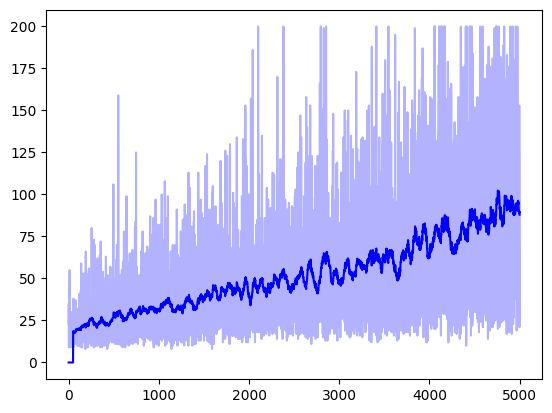

In [14]:
# Results and Plotting

env = gym.make('CartPole-v0', render_mode='rgb_array')

policy = PolicyApprox(n_states=len(env.observation_space.low),
                      n_actions=env.action_space.n)

REINFORCE_rewards = reinforce(env, policy, num_episodes=5000)
plt.figure()
plt.clf()
plt.plot(smooth_data(REINFORCE_rewards, window_width=50), 'b')
plt.plot(REINFORCE_rewards, 'b', alpha=0.3)
plt.show()

Num steps before failure: 200


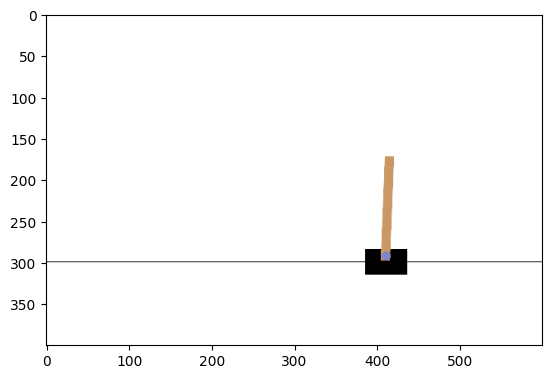

In [14]:
# Optional: See how your policy performed
rollout_data = rollout(env, policy, epsilon=0, do_visualize=True)
print(f"Num steps before failure: {len(rollout_data)}")

### P5.2.3 Implementing REINFORCE with Baseline

In L09, we discussed the REINFORCE with Baseline algorithm, as presented in Chapter 13.4 in Sutton & Barto. This approach requires training both the policy function and also an estimator for the state value function V. I have provided you with a class `VApprox` that you should use for this purpose.

**TASK/CODE** Complete the REINFORCE with baseline algorithm below using the lecture slides or Sutton & Barto as a reference (and, of course, your code from P5.2.2). Include your implementation of REINFORCE with baseline in your writeup.

**PLOTS** Run the Results & Plotting code using your newly-implemented REINFORCE with Baseline implementation. Include the plot in your writeup.

**QUESTION** (2–4 sentences) Run the Results & Plotting code a few more times (3–5 times will be sufficient) and comment on the similarities and differences between the results and behavior of the system (e.g., how does the random initial configuration impact the performance of the system?)

**QUESTION** (3–5 sentences) How does the performance of REINFORCE with Baseline compare to the plain REINFORCE algorithm from P5.2.2? Comment on their relative performance. Which would you prefer to use and why?

[Feel free to use the rollout + visualization code to visualize your result]

In [4]:
# Starter Code: REINFORCE with Baseline

class VApprox(torch.nn.Module):
    def __init__(self, n_states):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_states, 32),
            nn.Tanh(),
            nn.Linear(32, 1),
        )

    def forward(self, state):
        return 100 * self.linear_relu_stack(torch.tensor(state, dtype=torch.float))


def reinforce_with_baseline(env, policy, V, num_episodes, learning_rate=0.0005, gamma=0.95, epsilon0=0.1):
    optim = torch.optim.Adam(policy.parameters(), lr=learning_rate)  # optim
    v_optim = torch.optim.Adam(V.parameters(), lr=learning_rate)  # optim
    all_rewards = []
    
    for ind in range(num_episodes):
        rollout_data = rollout(env, policy, epsilon=epsilon0/np.log10(ind+2))

        G = 0
        loss = 0
        total_reward = 0
        v_loss = 0
        for state, action, reward, new_state, done in reversed(rollout_data):
            total_reward += reward
            G = gamma * G + reward
            v = V(state)
            delta = G - v
            pred = policy.get_action_log_prob(state, action)
            loss -= delta.detach()*pred
            v_loss += delta**2
        v_loss.backward()
        v_optim.step()
        v_optim.zero_grad()

        optim.zero_grad()
        loss.backward()
        optim.step()

        all_rewards.append(total_reward)
        if ind % 100 == 0:
            print(ind, total_reward, loss)
        

    return all_rewards

0 24.0 tensor([5.0660], grad_fn=<SubBackward0>)
100 54.0 tensor([333.0968], grad_fn=<SubBackward0>)
200 92.0 tensor([473.3393], grad_fn=<SubBackward0>)
300 43.0 tensor([-24.8683], grad_fn=<SubBackward0>)
400 47.0 tensor([15.3626], grad_fn=<SubBackward0>)
500 137.0 tensor([127.7599], grad_fn=<SubBackward0>)
600 122.0 tensor([207.4814], grad_fn=<SubBackward0>)
700 200.0 tensor([-102.9292], grad_fn=<SubBackward0>)
800 200.0 tensor([58.0361], grad_fn=<SubBackward0>)
900 200.0 tensor([88.4049], grad_fn=<SubBackward0>)
1000 200.0 tensor([-142.2125], grad_fn=<SubBackward0>)
1100 200.0 tensor([26.5872], grad_fn=<SubBackward0>)
1200 200.0 tensor([-130.1151], grad_fn=<SubBackward0>)
1300 200.0 tensor([7.5709], grad_fn=<SubBackward0>)
1400 200.0 tensor([77.2237], grad_fn=<SubBackward0>)
1500 200.0 tensor([-114.7368], grad_fn=<SubBackward0>)
1600 136.0 tensor([-76.9743], grad_fn=<SubBackward0>)
1700 148.0 tensor([-104.1822], grad_fn=<SubBackward0>)
1800 172.0 tensor([52.8790], grad_fn=<SubBackward

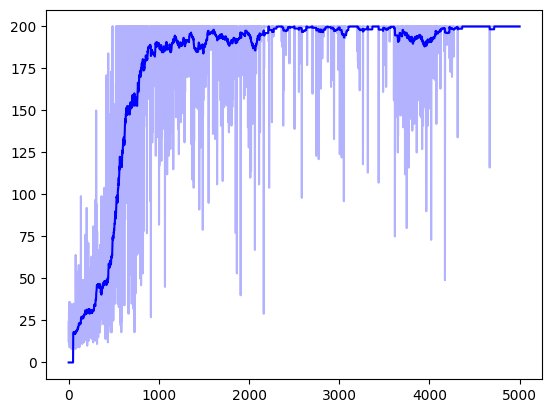

In [18]:
# Results and Plotting

env = gym.make('CartPole-v0', render_mode='rgb_array')

policy = PolicyApprox(n_states=len(env.observation_space.low),
                      n_actions=env.action_space.n)
V = VApprox(n_states=len(env.observation_space.low))

REINFORCE_with_baseline_rewards = reinforce_with_baseline(env, policy, V, num_episodes=5000)

plt.figure()
plt.clf()
plt.plot(smooth_data(REINFORCE_with_baseline_rewards, window_width=50), 'b')
plt.plot(REINFORCE_with_baseline_rewards, 'b', alpha=0.3)
plt.show()

### P5.2.3 Implementing Actor-Critic

Finally, you'll implement the Actor-Critic algorithm, a TD-version of the REINFORCE with Baseline training strategy. Using what you've implemented so far, you will complete the `actor_critic` function below.

**TASK/CODE** Complete the Actor-Critic algorithm below using the lecture slides or Sutton & Barto as a reference (and, of course, your code from P5.2.2). Include your implementation in your writeup.

**PLOTS** Run the Results & Plotting code using your newly-implemented REINFORCE with Baseline implementation. Include the plot in your writeup.

**QUESTION** (2–4 sentences) Run the Results & Plotting code a few more times (3–5 times will be sufficient) and comment on the similarities and differences between the results and behavior of the system (e.g., how does the random initial configuration impact the performance of the system?)

[Feel free to use the rollout + visualization code from above to visualize your result]

In [5]:
# Actor Critic Starter Code

def actor_critic(env, policy, V, num_episodes, learning_rate=0.0003, gamma=0.95, epsilon0=0.1):
    all_rewards = []
    # raise NotImplementedError()
    optim = torch.optim.Adam(policy.parameters(), lr=learning_rate)  # optim
    v_optim = torch.optim.Adam(V.parameters(), lr=learning_rate)  # optim
    
    for ind in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        loss = 0
        v_loss = 0
        v = 0
        while not done:
            action = policy.sample_action(state, epsilon0)
            try: 
                new_state, reward, terminated, truncated, _ = env.step(action)
            except:
                new_state, reward, terminated, truncated, _ = env.step([action])
            done = terminated or truncated
            total_reward += reward
            v = V(state)
            v_new = V(new_state)
            if done:
                delta = reward - v
            else:
                delta = reward + gamma*v_new.detach() - v
            pred = policy.get_action_log_prob(state, action)
            loss = -gamma*delta.detach()*pred
            v_loss = delta**2
            state = new_state.copy()
            v_loss.backward()
            v_optim.step()
            v_optim.zero_grad()
            optim.zero_grad()
            loss.backward()
            optim.step()           
            

        all_rewards.append(total_reward)
        if ind % 100 == 0:
            print(ind, total_reward, loss)
    return all_rewards

0 16.0 tensor([-7.9602], grad_fn=<MulBackward0>)
100 17.0 tensor([-10.4409], grad_fn=<MulBackward0>)
200 25.0 tensor([-7.6930], grad_fn=<MulBackward0>)
300 35.0 tensor([-1.6341], grad_fn=<MulBackward0>)
400 45.0 tensor([-0.2226], grad_fn=<MulBackward0>)
500 180.0 tensor([-1.5773], grad_fn=<MulBackward0>)
600 200.0 tensor([-2.3023], grad_fn=<MulBackward0>)
700 172.0 tensor([-0.8087], grad_fn=<MulBackward0>)
800 200.0 tensor([-0.2373], grad_fn=<MulBackward0>)
900 200.0 tensor([-15.6918], grad_fn=<MulBackward0>)
1000 200.0 tensor([-9.7451], grad_fn=<MulBackward0>)
1100 178.0 tensor([-3.7688], grad_fn=<MulBackward0>)
1200 200.0 tensor([-20.9264], grad_fn=<MulBackward0>)
1300 200.0 tensor([-0.5673], grad_fn=<MulBackward0>)
1400 200.0 tensor([-5.5701], grad_fn=<MulBackward0>)
1500 200.0 tensor([-6.1056], grad_fn=<MulBackward0>)
1600 200.0 tensor([-0.4783], grad_fn=<MulBackward0>)
1700 200.0 tensor([-38.5982], grad_fn=<MulBackward0>)
1800 200.0 tensor([-10.7353], grad_fn=<MulBackward0>)
1900 

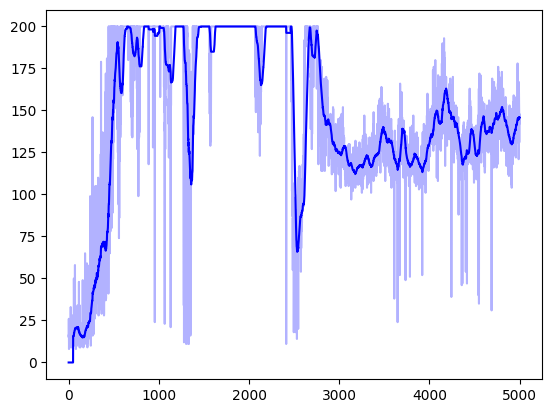

In [23]:
# Results and Plotting

env = gym.make('CartPole-v0', render_mode='rgb_array')

policy = PolicyApprox(n_states=len(env.observation_space.low),
                      n_actions=env.action_space.n)
V = VApprox(n_states=len(env.observation_space.low))

actor_critic_rewards = actor_critic(env, policy, V, num_episodes=5000)

plt.figure()
plt.clf()
plt.plot(smooth_data(actor_critic_rewards, window_width=50), 'b')
plt.plot(actor_critic_rewards, 'b', alpha=0.3)
plt.show()

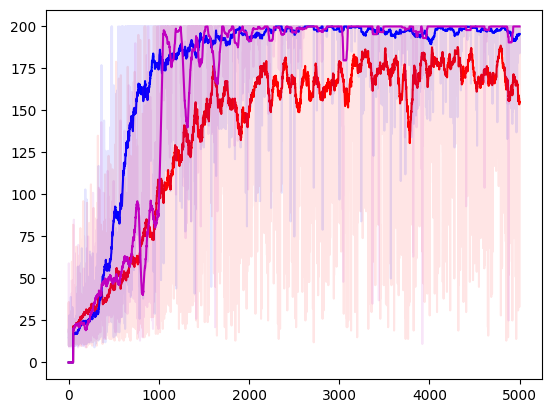

In [44]:
# Show all three on the same plot
plt.figure()
plt.clf()
rewards_list = [REINFORCE_rewards, REINFORCE_with_baseline_rewards, actor_critic_rewards]
for rewards, fmt in zip(rewards_list, ['r', 'b', 'm']):
    plt.plot(rewards, fmt, alpha=0.1)
    plt.plot(smooth_data(rewards, window_width=50), fmt)
plt.show()

## P5.3 Continuous Action Policy Optimization

Next you will tackle a continuous action space, something for which policy gradient methods are well-suited. You have already implemented the training algorithms in P5.2! All that is left is to define the approximate policy function.

You will tackle the Pendulum environment, detailed here: https://gymnasium.farama.org/environments/classic_control/pendulum/

**TASK** Complete the . I have provided you with some starter code here. Note that the `forward` function returns a two-element tuple, that consists of the mean and standard deviation that will serve as inputs to the Normal/Gaussian distribution. Fortunately, PyTorch has a number of built-in functions for this purpose, and defines everything you need to sample from a Gaussian distribution. Use the `torch.distributions` module [ documentation : https://pytorch.org/docs/stable/distributions.html ] to define the `sample_action` and `get_action_log_prob` functions in the partial implementation below. Note that this implementation is not epsilon-greedy, so don't worry about picking a "uniform random" action some percent of the time.

**CODE** Include your impementations of `sample_action` and `get_action_log_prob` in your writeup.

**PLOTS** Run the code below and include the resulting plots—showing the results for each approach on the Pendulum problem—in your writeup. If your policy code is set up properly, it should run without error. [In my experiments, the policy did fairly well much of the time, though not quite always; if you are confident in your implementation, running it again may yield better results. You can tune the parameters if you like, though I do not believe it will be necessary, and will take time (and sanity) you need not lose to 
this assignment.]

**TASK/PLOTS** Change the pendulum environmentgravity parameter `g` to `5.0` (m/s^2) and rerun the results. Include the resulting three-curve plot in your writeup.

**QUESTION** (5–7 sentences) How does the performance change when you increase the gravity. Why? What does ideal behavior look like? Why is it so difficult to learn this behavior? Comment on what might be necessary to achieve better performance. *Note: you may need to look deeper into the pendulum environment or reason how you might solve this problem; you might also want to visualise your policy using the visualization code I have provided below.*

In [6]:
## Starter Code

class PolicyApproxGaussian(torch.nn.Module):
    def __init__(self, n_states):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_states, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 2),
            nn.Tanh()
        )
    def sample_action(self, state, epsilon=0.0):
        action_means, action_stddevs = self.forward(state)
        # action_stddevs += 1e-6  # A trick to improve numerical stability
        if torch.abs(action_means) <1e-6:
            action_means = torch.tensor(0, dtype=torch.float)
        if torch.abs(action_stddevs) < 1e-6:
            action_stddevs = torch.tensor(1e-6, dtype=torch.float)       
        dist = torch.distributions.Normal(2*action_means, action_stddevs)
        if epsilon > 0.0:
            raise ValueError("No 'epsilon greedy' for this policy.")
        action = dist.sample() 
        return action.numpy()

    def get_action_log_prob(self, state, action):
        action_means, action_stddevs = self(state)
        if torch.abs(action_means) <1e-6:
            action_means = torch.tensor(0, dtype=torch.float)
        if torch.abs(action_stddevs) < 1e-6:
            action_stddevs = torch.tensor(1e-6, dtype=torch.float)
        dist = torch.distributions.Normal(2*action_means, action_stddevs)
        return dist.log_prob(torch.tensor(action, dtype=torch.float))
    
    def forward(self, state):
        return self.linear_relu_stack(torch.tensor(state, dtype=torch.float))

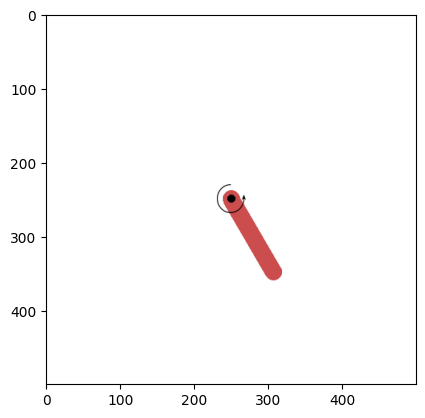

In [55]:
# Visualiation Code (random policy)

env_cont = gym.make("Pendulum-v1", g=2.0, render_mode='rgb_array')
policy = PolicyApproxGaussian(n_states=len(env_cont.observation_space.low))
rollout_data = rollout(env_cont, policy, epsilon=0, do_visualize=True)

/home/dzungbui/.local/lib/python3.10/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 -1321.4911753779913 tensor(-43436.6992, grad_fn=<SubBackward0>)
100 -1219.5281012026512 tensor(-36301.9062, grad_fn=<SubBackward0>)
200 -1035.5747850700275 tensor(-31321.2246, grad_fn=<SubBackward0>)
300 -1016.6419381967883 tensor(-33692.8203, grad_fn=<SubBackward0>)
400 -1224.7967527304047 tensor(-52222.9062, grad_fn=<SubBackward0>)
500 -1538.7514566998234 tensor(-53078.5312, grad_fn=<SubBackward0>)
600 -1662.6155978548506 tensor(-63871.6797, grad_fn=<SubBackward0>)
700 -1134.8923565711516 tensor(-43770.6250, grad_fn=<SubBackward0>)
800 -1715.4760859044927 tensor(-68353.2422, grad_fn=<SubBackward0>)
900 -1149.345217229057 tensor(-49668.6992, grad_fn=<SubBackward0>)
1000 -1271.4500520295062 tensor(-51035.6836, grad_fn=<SubBackward0>)
1100 -1243.9863691274522 tensor(-54072.7266, grad_fn=<SubBackward0>)
1200 -1570.8605442005155 tensor(-68551.8828, grad_fn=<SubBackward0>)
1300 -1056.856398910831 tensor(-46829.8516, grad_fn=<SubBackward0>)
1400 -1784.4093038486872 tensor(-77070.5391, gra

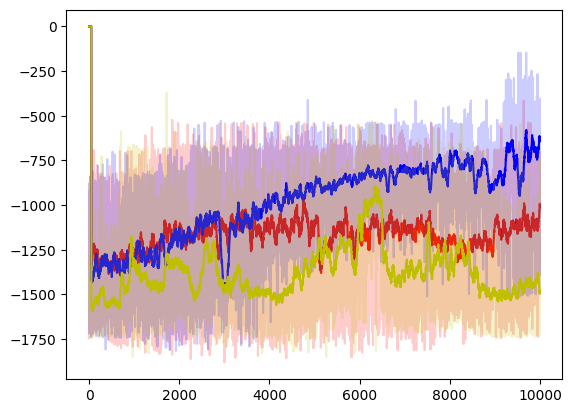

In [7]:
# Results and Plotting

# I have provided you with a slightly different V function.
# I found it to work better for the Pendulum example.

class VApproxDeeper(torch.nn.Module):
    def __init__(self, n_states):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_states, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def forward(self, state):
        return 100 * self.linear_relu_stack(torch.tensor(state, dtype=torch.float))


env_cont = gym.make("Pendulum-v1", g=5.0, render_mode='rgb_array')

policy = PolicyApproxGaussian(n_states=len(env_cont.observation_space.low))
REINFORCE_rewards = reinforce(
    env_cont, policy, num_episodes=10000, 
    learning_rate=0.001, gamma=0.98, epsilon0=0.0)

policy = PolicyApproxGaussian(n_states=len(env_cont.observation_space.low))
V = VApproxDeeper(n_states=len(env_cont.observation_space.low))
REINFORCE_baseline_rewards = reinforce_with_baseline(
    env_cont, policy, V, num_episodes=10000, 
    learning_rate=0.001, gamma=0.98, epsilon0=0.0)

policy = PolicyApproxGaussian(n_states=len(env_cont.observation_space.low))
V = VApproxDeeper(n_states=len(env_cont.observation_space.low))
actor_critic_rewards = actor_critic(
    env_cont, policy, V, num_episodes=10000, 
    learning_rate=0.001, gamma=0.98, epsilon0=0.0)

# Show all three on the same plot
plt.figure()
plt.clf()
rewards_list = [REINFORCE_rewards, REINFORCE_baseline_rewards, actor_critic_rewards]
for rewards, fmt in zip(rewards_list, ['r', 'b', 'y']):
    plt.plot(rewards, fmt, alpha=0.2)
    plt.plot(smooth_data(rewards, window_width=50), fmt)
plt.show()

In [ ]:
# Visualiation
rollout_data = rollout(env_cont, policy, epsilon=0, do_visualize=True)
print(f"Num steps before failure: {len(rollout_data)}")

## P5.4 Running PPO

While I do not want you to *implement* PPO, I did want you to play around with it a bit. I have found a package that implementes PPO and some utilities for fast training, data logging, etc. You'll use this instead for this final question

**TASK** First install `stable_baselines3` using the `%pip install` command below.

**TASK** Run the training and evaluation code that follows for `gravity = 2.0` and `gravity = 5.0` and `gravity = 9.81`. Run the code a few times to see how performance varies with random seed.

**PLOTS** When run, the code will generate "monitor.csv" files in the local folder `PPO_monitor_outs` that the code below reads in and plots. Include plots for each value of gravity.

**QUESTION** (3–4 sentences) How quickly does the system learn as a function of the gravity parameter. Comment on how this is or is not consistent with your results from your own implementation?

In [19]:
%pip install stable_baselines3

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


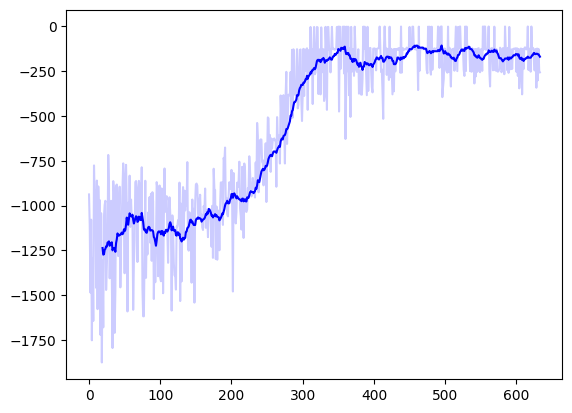

In [35]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env
import pandas as pd

gravity = 9.81
# env_cont = gym.make("Pendulum-v1", g=gravity, render_mode='rgb_array')

# # Parallel environments
# vec_env = make_vec_env("Pendulum-v1", n_envs=4, env_kwargs={'g': gravity}, monitor_dir='PPO_monitor_outs')
# model = PPO("MlpPolicy", vec_env, verbose=1).learn(500000)

results_df = pd.read_csv("PPO_monitor_outs/3.monitor.csv", header=1)
plt.figure()
plt.plot(results_df['r'], 'b', alpha=0.2)
plt.plot(results_df.rolling(20).mean()['r'], 'b')
plt.show()